In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
import mplfinance as mpf


## Importing The Data **set**

In [ ]:
# Load the dataset
df = pd.read_csv('BTC_data1.csv', parse_dates=['Date'], index_col='Date')
df = df.sort_index()

<ipython-input-79-078f484566e3>:2: UserWarning:

Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.



In [ ]:
df.head()

,Close,High,Low,Open,Volume
Date,,,,,
2014-09-17,457.334015,468.174011,452.421997,465.864014,21056800.0
2014-09-18,424.440002,456.859985,413.104004,456.859985,34483200.0
2014-09-19,394.795990,427.834992,384.532013,424.102997,37919700.0
2014-09-20,408.903992,423.295990,389.882996,394.673004,36863600.0
2014-09-21,398.821014,412.425995,393.181000,408.084992,26580100.0


In [ ]:
# Filter for COVID Period (April 2020 - Dec 2021)
df = df.loc['2020-04-01':'2021-12-31']


**Exploratory Data Analysis**

****

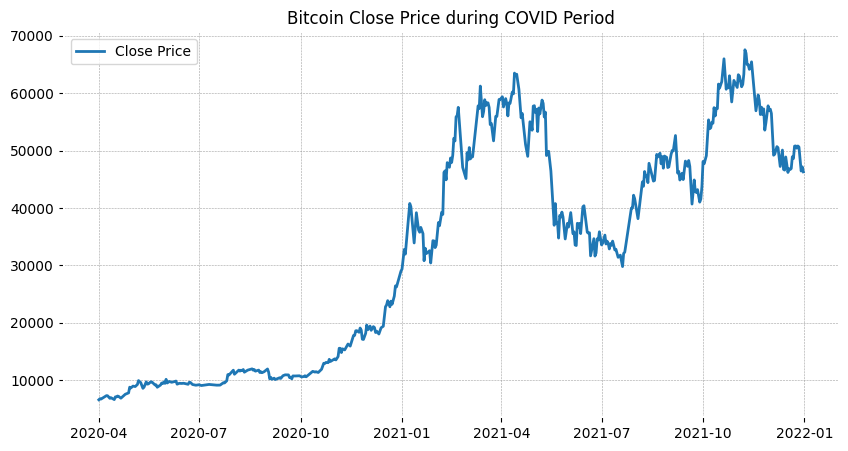

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(df['Close'], label='Close Price')
plt.title('Bitcoin Close Price during COVID Period')
plt.legend()
plt.show()


# Checking Stationarity

In [ ]:
result = adfuller(df['Close'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


ADF Statistic: -1.2840448244743472
p-value: 0.6364398482737662


As p value is greater than 0.05 that means the data is non stationary


#Differencing to make it stationary

In [ ]:
df['Close_diff'] = df['Close'].diff().dropna()
result_diff = adfuller(df['Close_diff'].dropna())
print(f'ADF Statistic after differencing: {result_diff[0]}')
print(f'p-value after differencing: {result_diff[1]}')


ADF Statistic after differencing: -26.30025006685403
p-value after differencing: 0.0


#Seasonal decomposition

In [ ]:
decomp = seasonal_decompose(df['Close'], model='additive', period=30)
df['Seasonal_Component'] = decomp.seasonal
df['Trend_Component'] = decomp.trend


# Correlation Analysis

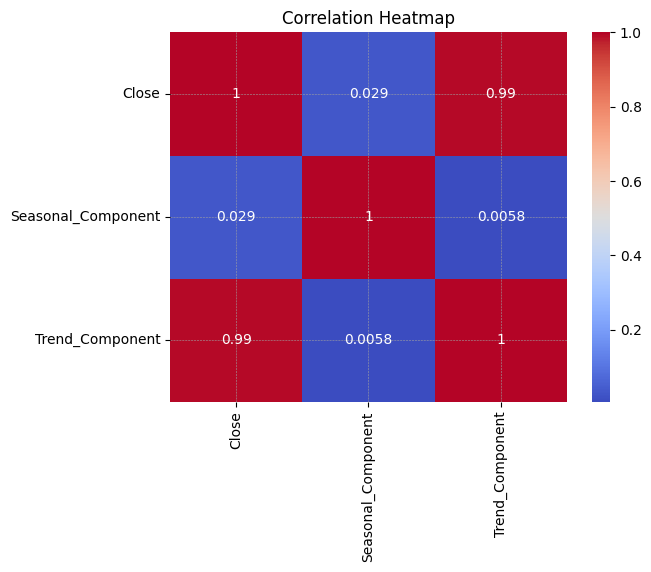

In [ ]:

correlation_matrix = df[['Close', 'Seasonal_Component', 'Trend_Component']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()



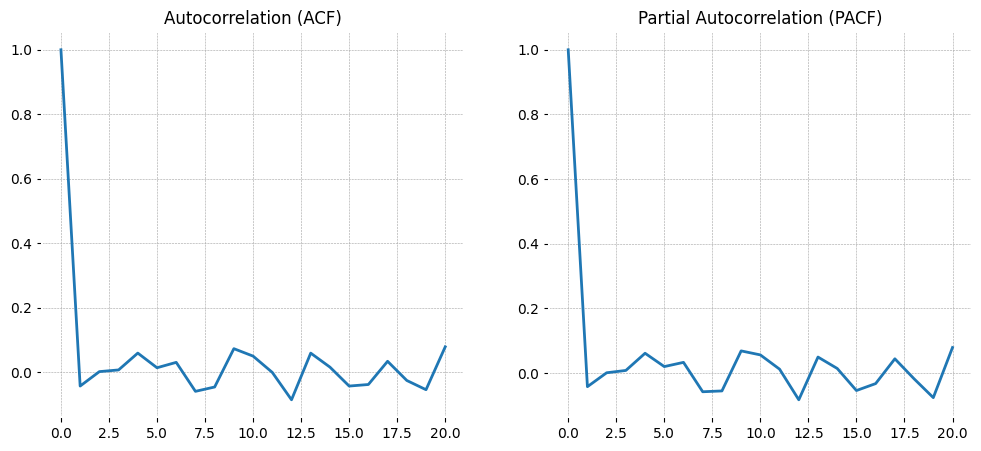

In [ ]:
# ACF and PACF Plots
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.lineplot(x=range(len(acf(df['Close_diff'].dropna(), nlags=20))), y=acf(df['Close_diff'].dropna(), nlags=20), ax=ax[0])
ax[0].set_title('Autocorrelation (ACF)')
sns.lineplot(x=range(len(pacf(df['Close_diff'].dropna(), nlags=20))), y=pacf(df['Close_diff'].dropna(), nlags=20), ax=ax[1])
ax[1].set_title('Partial Autocorrelation (PACF)')
plt.show()


In [ ]:
# Fitting ARIMA Model
model = ARIMA(df['Close'], order=(1,1,1))
model_fit = model.fit()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



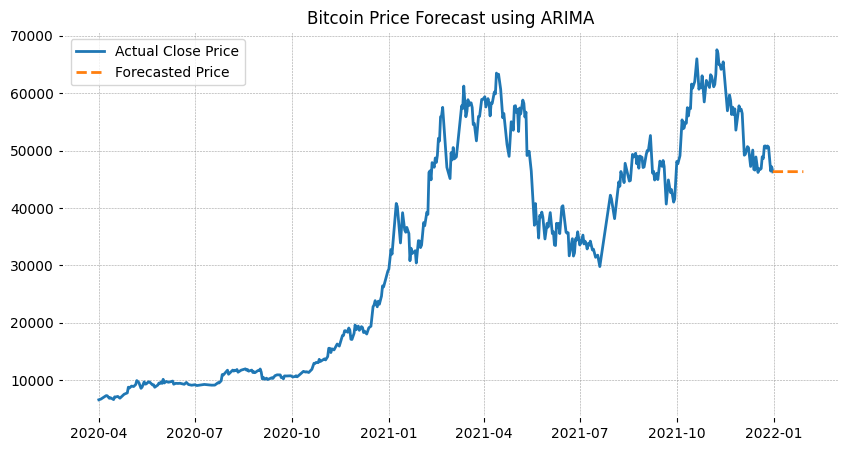

In [ ]:
# Forecasting
forecast = model_fit.forecast(steps=30)
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Close'], label='Actual Close Price')
plt.plot(pd.date_range(start=df.index[-1], periods=30, freq='D'), forecast, label='Forecasted Price', linestyle='dashed')
plt.title('Bitcoin Price Forecast using ARIMA')
plt.legend()
plt.show()


In [ ]:
# Evaluating Model
from sklearn.metrics import mean_absolute_error
print(f'MAE: {mean_absolute_error(df.Close[-30:], forecast[:30])}')


MAE: 2669.756461702188
